In [51]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc

from scipy import optimize

In [52]:
plt.style.use('notebook')

In [53]:
t = Table(fits.getdata('../data/pal5_ls_lite_grz.fits'))

In [4]:
points = np.array([t['g'] - t['r'], t['g']]).T
gr = t['g'] - t['r']
gz = t['g'] - t['z']

In [5]:
ceq = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, frame='icrs')
cpal = ceq.transform_to(gc.Pal5)

wangle = 180*u.deg

In [6]:
iso = Table.read('../data/mist_11.5_-1.30.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

In [7]:
bin_size = 2
phi1_bins = np.arange(np.min(cpal.phi1.wrap_at(wangle).deg),
                      np.max(cpal.phi1.wrap_at(wangle).deg)+1e-3, bin_size) * u.deg

In [8]:
bin_spacing = 3*u.deg
bin_width = 3*u.deg

be0 = np.arange(-15, 10, bin_spacing.to(u.deg).value)*u.deg
be1 = be0 + bin_width

bc = 0.5 * (be0 + be1)
Nb = np.size(bc)

delta_dm = np.zeros(Nb)
delta_dm[8] = -0.6
delta_dm[8] = -0.5
delta_dm[7] = -0.35
delta_dm[6] = -0.15

# # guess
# delta_dm[1] = 0.08
# delta_dm[2] = 0.06
# delta_dm[3] = 0.04
# delta_dm[4] = 0.02

# # from ibata+2016
# delta_dm[0] = 0.1

# delta_dm[8] = -0.3
# delta_dm[7] = -0.15
# delta_dm[6] = -0.05
# delta_dm[4] = -0.02

# guess
delta_dm[1] = 0.08
delta_dm[2] = 0.06
delta_dm[3] = 0.04
delta_dm[4] = 0.02

# from ibata+2016
delta_dm[0] = 0.1

# pfit = np.polyfit(bc.value, delta_dm, deg=2)
# # pfit = np.polyfit(bc[np.r_[0,6:9]].value, delta_dm[np.r_[0,6:9]], deg=2)
# poly_dm = np.poly1d(pfit)

In [9]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [10]:
p_dm, e = optimize.curve_fit(piecewise_linear, bc, delta_dm)

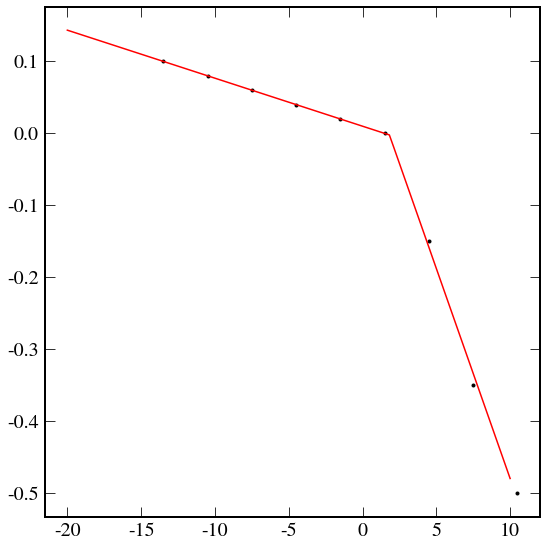

In [11]:
phi1_grid = np.linspace(-20,10,100)
dm_grid = piecewise_linear(phi1_grid, *p_dm)
plt.plot(bc, delta_dm, 'k.')
plt.plot(phi1_grid, dm_grid, 'r-')

plt.tight_layout()

In [12]:
phi1_cen = 0.5 * (phi1_bins[1:] + phi1_bins[:-1])
N = len(phi1_cen)

mask = np.zeros(len(t), dtype='bool')

distance_app = 22.5*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gr = iso['DECam_g']-iso['DECam_r'] + 0.06
i_g = iso['DECam_g']+dm

i_left = i_gr - 0.12*(i_g/28)**5
i_right = i_gr + 0.12*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<23.7) & (poly[:,1]>20)
poly_main = poly[ind]

In [13]:
p_grz = np.array([1.7,-0.17])
grz_poly = np.poly1d(p_grz)

In [14]:
mask = np.zeros(len(t), dtype='bool')
gr_mask = np.zeros(len(t), dtype='bool')
grz_mask = np.zeros(len(t), dtype='bool')

for i in range(N):
    distance_app = 22.5*u.kpc
    dm = 5*np.log10((distance_app.to(u.pc)).value)-5
    dm += piecewise_linear(phi1_cen[i].value, *p_dm)

    # main sequence + rgb
    i_gr = iso['DECam_g']-iso['DECam_r'] + 0.06
    i_g = iso['DECam_g']+dm

    i_left = i_gr - 0.12*(i_g/28)**5
    i_right = i_gr + 0.12*(i_g/28)**5

    poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
#     if phi1_bins[i]>0:
#         ind = (poly[:,1]<24) & (poly[:,1]>20)
#     else:
    ind = (poly[:,1]<23) & (poly[:,1]>20)
    poly_main = poly[ind]
    path_main = mpl.path.Path(poly_main)
    
    # contains path takes a while -- working in phi1 stripes
    phi1_mask = (cpal.phi1.wrap_at(wangle)>phi1_bins[i]) & (cpal.phi1.wrap_at(wangle)<=phi1_bins[i+1])
    inmask = phi1_mask==True

    gr_mask_ = path_main.contains_points(points[phi1_mask])
    
    grz_mask_ = ((gz[phi1_mask]<grz_poly(gr[phi1_mask])+0.13) & 
               (gz[phi1_mask]>grz_poly(gr[phi1_mask])-0.13))
    
    # save cmd masks
    cmd_mask = gr_mask_ & grz_mask_
    gr_mask[inmask] = gr_mask_
    grz_mask[inmask] = grz_mask_
    
    # because double index edits don't work
    _tmp = [True if cmd_mask[e] else False for e in range(np.size(cmd_mask))]
    phi1_mask[inmask] = _tmp
    
    mask = mask | phi1_mask   

/usr/lib64/python3.6/site-packages/numpy/lib/polynomial.py:736: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
/usr/lib64/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/usr/lib64/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


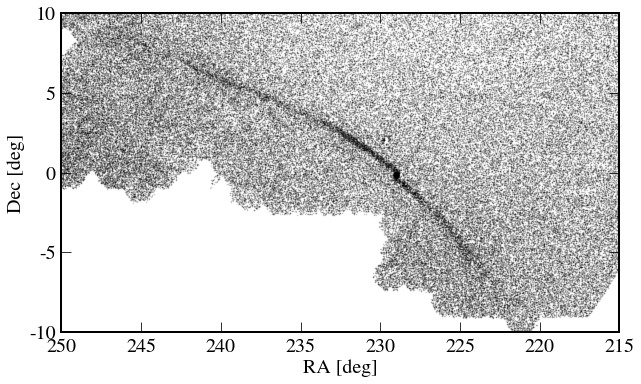

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,15))

plt.plot(ceq.ra[mask], ceq.dec[mask], 'k.', ms=1, alpha=0.2)
# plt.plot(226.8, -2.3, 'o', color='none', mec='r', ms=10)

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

plt.xlim(250, 215)
plt.ylim(-10,10)

# plt.gca().invert_xaxis()
plt.gca().set_aspect('equal')
plt.savefig('../plots/decals_pal5_distgrad_grz4.png', dpi=150)

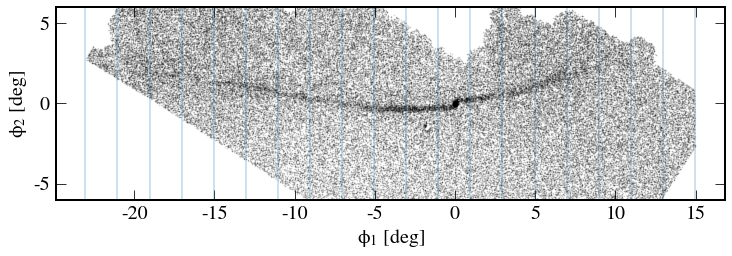

In [16]:
fig, ax = plt.subplots(1,1,figsize=(12,10))

plt.plot(cpal.phi1.wrap_at(wangle)[mask], cpal.phi2[mask], 'k.', ms=1, alpha=0.17)

for e in phi1_bins:
    plt.axvline(e.value, alpha=0.3)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.ylim(-6,6)

plt.gca().set_aspect('equal')

In [17]:
# save flags
tout = Table([gr_mask, grz_mask], names=('gr_mask', 'grz_mask'))
tout.write('../data/cmd_masks_orig.fits', overwrite=True)

## Density map

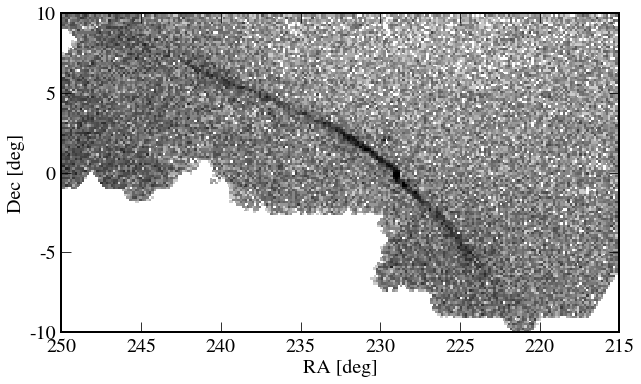

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,15))

plt.hist2d(ceq.ra[mask], ceq.dec[mask], bins=(np.arange(215,250,0.15), np.arange(-10,10,0.15)), cmap='binary',
          norm=mpl.colors.LogNorm(), vmin=1, vmax=30)

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

plt.xlim(250, 215)
plt.ylim(-10,10)

# plt.gca().invert_xaxis()
plt.gca().set_aspect('equal')

### Dust map

In [20]:
from dustmaps.sfd import SFDQuery

In [21]:
dp = 0.05
dp1 = np.arange(215, 250+dp, dp)
dp2 = np.arange(-10, 10+dp, dp)
dp1, dp2 = np.meshgrid(dp1, dp2)
cdust = coord.SkyCoord(dp1*u.deg, dp2*u.deg, distance=22.5*u.kpc, frame='icrs')
cdust_eq = cdust.transform_to(coord.Galactic)
cdust_sc = coord.SkyCoord(cdust_eq.l, cdust_eq.b, frame='galactic')

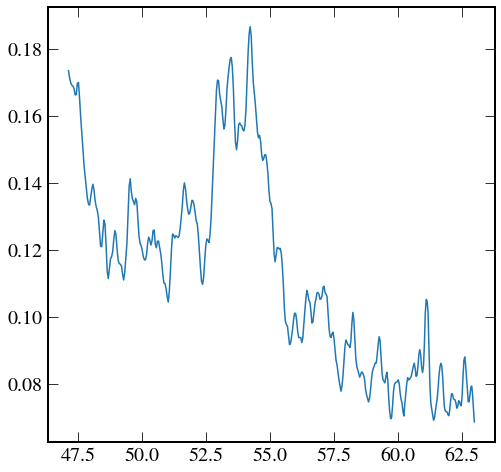

In [35]:
plt.plot(cdust_sc[:,0].b.deg, Av_sfd[:,0], '-')

In [22]:
sfd = SFDQuery()
Av_sfd = 2.742 * sfd(cdust_sc)

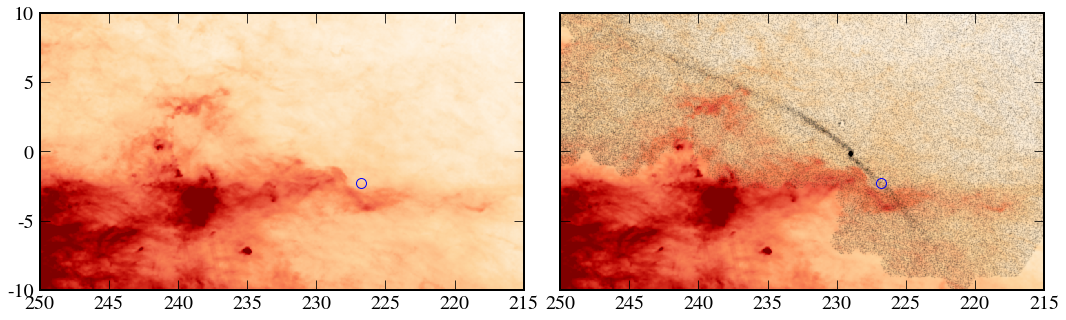

In [48]:
# dust map
fig, ax = plt.subplots(1,2,figsize=(15,4.9), sharey=True)

plt.sca(ax[0])
im = plt.imshow(np.sqrt(Av_sfd)[::,::-1], extent=[250,215,-10,10], origin='lower', vmax=1,
           interpolation='nearest', cmap='OrRd', aspect='equal')
plt.plot(226.8, -2.3, 'o', color='none', mec='b', ms=10, zorder=2)

plt.gca().set_aspect('equal')
plt.xlim(250,215)

plt.sca(ax[1])
im = plt.imshow(np.sqrt(Av_sfd)[::,::-1], extent=[250,215,-10,10], origin='lower', vmax=1,
           interpolation='nearest', cmap='OrRd', aspect='equal')
plt.plot(ceq.ra[mask], ceq.dec[mask], 'k.', ms=1, alpha=0.05, zorder=1)
plt.plot(226.8, -2.3, 'o', color='none', mec='b', ms=10, zorder=2)

plt.gca().set_aspect('equal')
plt.xlim(250,215)

plt.tight_layout()

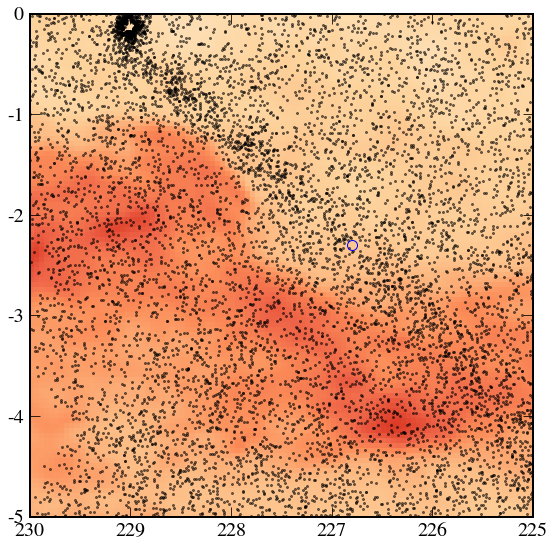

In [49]:
im = plt.imshow(np.sqrt(Av_sfd)[::,::-1], extent=[250,215,-10,10], origin='lower', vmax=1.,
           interpolation='nearest', cmap='OrRd', aspect='equal')
plt.plot(ceq.ra[mask], ceq.dec[mask], 'k.', ms=4, alpha=0.5, zorder=1)
plt.plot(226.8, -2.3, 'o', color='none', mec='b', ms=10, zorder=2)

plt.gca().set_aspect('equal')
plt.xlim(230,225)
plt.ylim(-5,0)
plt.tight_layout()

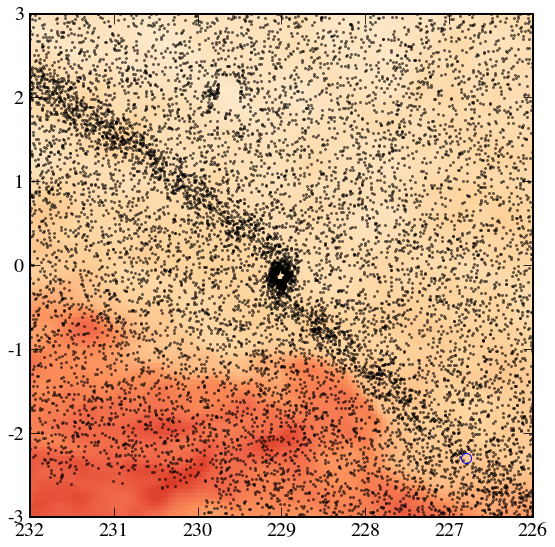

In [50]:
im = plt.imshow(np.sqrt(Av_sfd)[::,::-1], extent=[250,215,-10,10], origin='lower', vmax=1.,
           interpolation='nearest', cmap='OrRd', aspect='equal')
plt.plot(ceq.ra[mask], ceq.dec[mask], 'k.', ms=4, alpha=0.5, zorder=1)
plt.plot(226.8, -2.3, 'o', color='none', mec='b', ms=10, zorder=2)

plt.gca().set_aspect('equal')
plt.xlim(232,226)
plt.ylim(-3,3)
plt.tight_layout()

### Number of stars to fit

In [86]:
ra0 = 229.022083*u.deg
dec0 = -0.111389*u.deg

In [ ]:
# find eq coordinates of a larger box
p1 = np.array([-25, -25, 15, 15])*u.deg
p2 = np.array([-6, 6, 6, -6])*u.deg

box_cpal = gc.Pal5(p1, p2)
box_ceq = box_cpal.transform_to(coord.ICRS)

In [ ]:
plt.plot(box_ceq.ra, box_ceq.dec, 'ko')
plt.gca().set_aspect('equal')

print(np.min(box_ceq.ra.deg), np.max(box_ceq.ra.deg))
print(np.min(box_ceq.dec.deg), np.max(box_ceq.dec.deg))